In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Regression

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

In [3]:
np.random.seed(306)

In [4]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [5]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

In [6]:
dt_reg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                            ('dt_reg', DecisionTreeRegressor(max_depth=3, random_state=42))])

dt_reg_cv_results = cross_validate(dt_reg_pipeline, com_train_features, com_train_labels, 
                                   cv=cv, scoring='neg_mean_absolute_error', return_train_score=True, return_estimator=True)

dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(dt_reg_train_error.mean(), dt_reg_train_error.std()) # Mean absolute training error
print(dt_reg_test_error.mean(), dt_reg_test_error.std()) # Mean absolute test error

0.5895995682120934 0.004873994610268372
0.5926692636750868 0.006672158499231682


Visualizing using Tree diagram

In [7]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

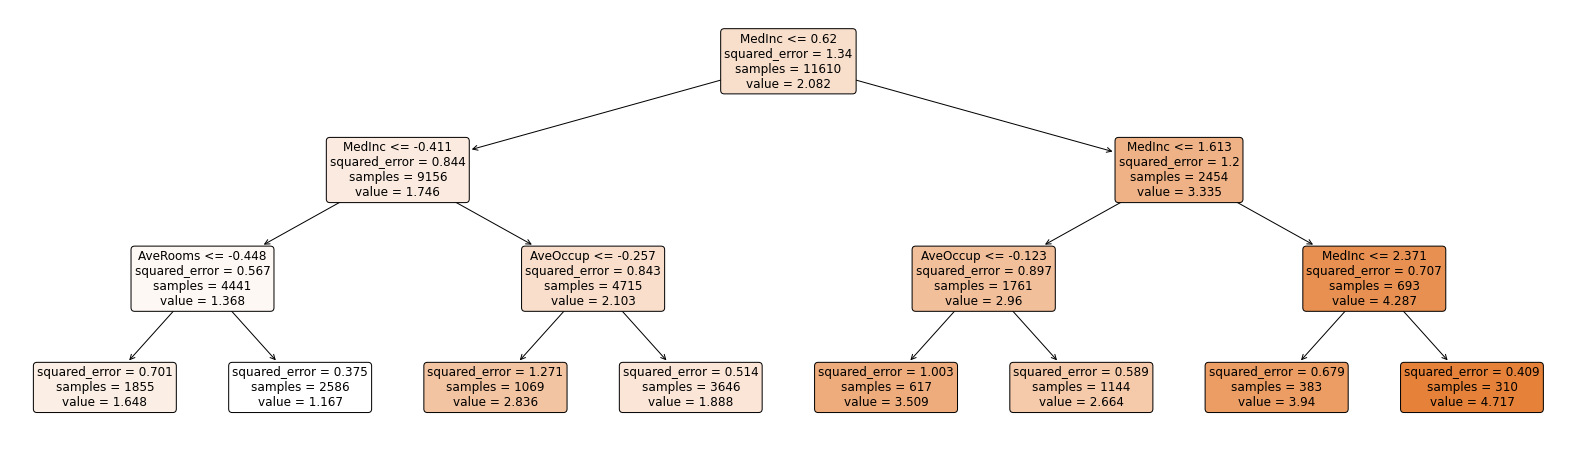

In [8]:
plt.figure(figsize=(28,8), facecolor='w')
a = tree.plot_tree(dt_reg_pipeline[-1], feature_names=features.columns, rounded=True, filled=True, fontsize=12)

In [9]:
tree_rules = export_text(dt_reg_pipeline[-1])
print(tree_rules )

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



In [10]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

In [11]:
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print(f"MAE: {mae}, MSE: {mse}, r2 score: {r2}")

MAE: 0.6005762942842664, MSE: 0.6417557936098145, r2 score: 0.5150037690483743


In [12]:
param_grid = {'dt_reg__max_depth': range(1, 20), 'dt_reg__min_samples_split': range(2, 8)}

dt_grid_search = GridSearchCV(dt_reg_pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error', return_train_score=True)
dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [13]:
mean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = -1 * dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = -1 * dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

In [14]:
print(mean_train_error, std_train_error)
print(mean_test_error, std_test_error)

0.27823056836739307 -0.0064898307245129586
0.4283313044233501 -0.011693730815682686


In [15]:
print(dt_grid_search.best_score_)

-0.4283313044233501


In [16]:
print(dt_grid_search.best_params_)

{'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}


In [17]:
dt_reg_pipeline.set_params(dt_reg__max_depth=11, dt_reg__min_samples_split=5).fit(com_train_features, com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

Alternatively...

In [18]:
dt_grid_search.best_estimator_.fit(com_train_features, com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [19]:
test_labels_pred = dt_reg_pipeline.predict(test_features)
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print(f"MAE: {mae}, MSE: {mse}, r2 score: {r2}")

MAE: 0.4248952183820017, MSE: 0.4154957726373763, r2 score: 0.6859960039130073


## Classification

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',names=column_names)

In [23]:
abalone_data

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6b9a25050>,
      dtype=object)

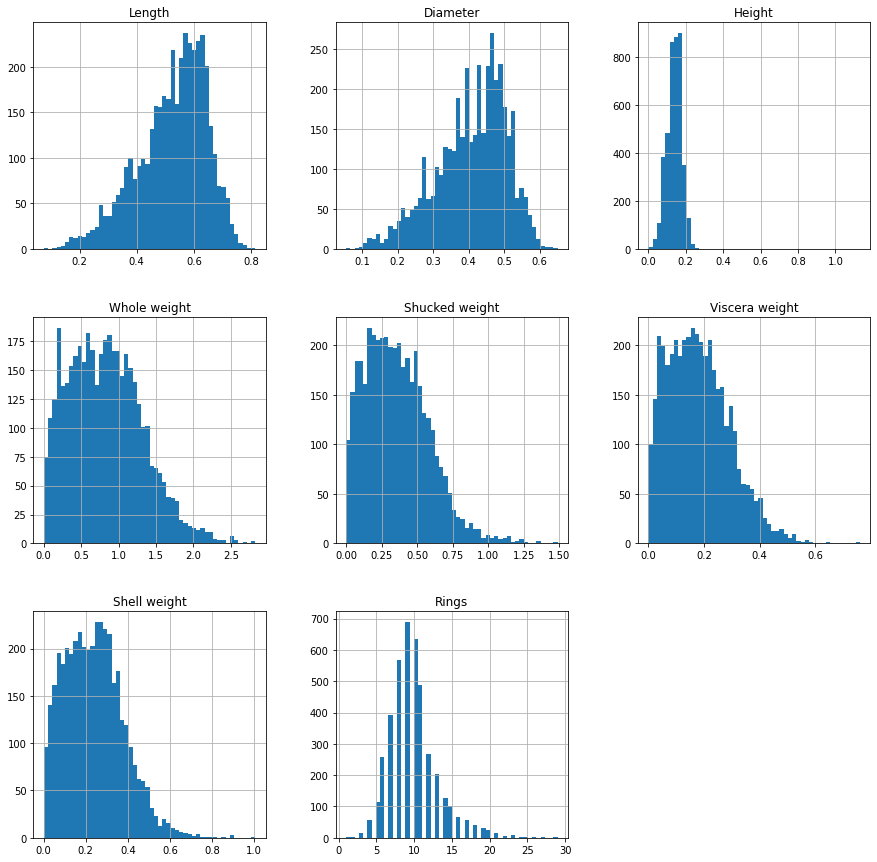

In [24]:
abalone_data.hist(bins=50, figsize=(15, 15))

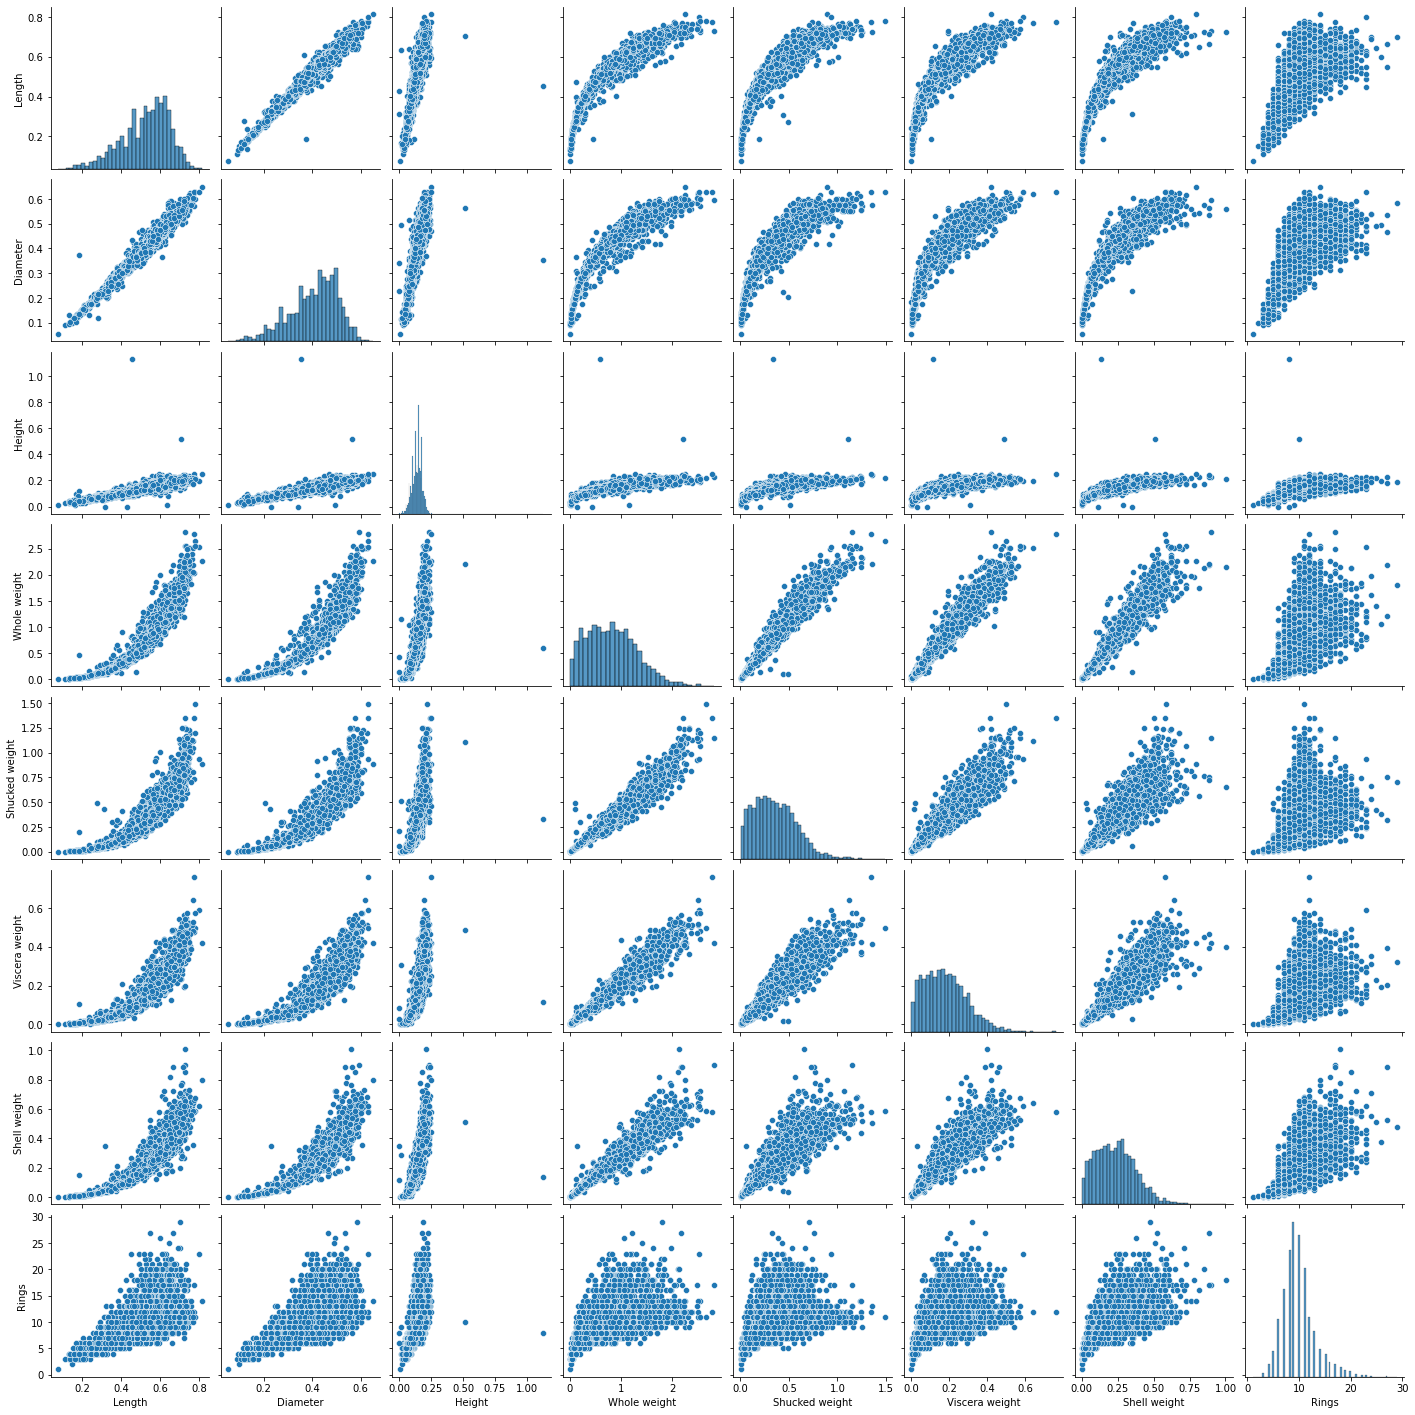

In [25]:
sns.pairplot(abalone_data, diag_kind='hist')

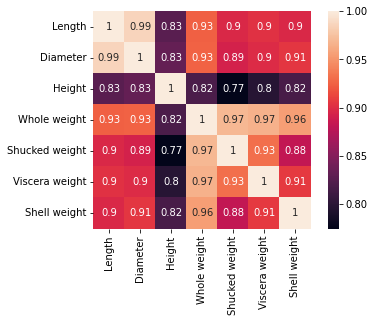

In [26]:
sns.heatmap(abalone_data.iloc[:, :-1].corr(), annot=True, square=True)

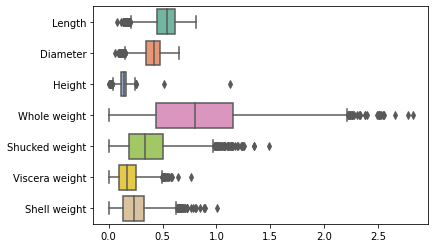

In [27]:
sns.boxplot(data=abalone_data.iloc[:, :-1], orient='h', palette='Set2')

In [28]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [29]:
abalone_data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [30]:
abalone_data['Rings'].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

In [31]:
abalone_data['Rings'].value_counts().sort_index()

1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: Rings, dtype: int64

In [32]:
abalone_data[abalone_data['Height'] == 0] # two rows with height=0

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [33]:
(abalone_data['Height'] == 0).sum()

2

In [34]:
means = pd.pivot_table(abalone_data, index=['Sex'], aggfunc={'Height': np.mean})
means

,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


We'll use the mean infant height of 0.107 from above table to fill in for missing values

In [35]:
X = abalone_data.iloc[:, :-1]
y = abalone_data.iloc[:, -1]

In [36]:
X.shape, y.shape

((4177, 8), (4177,))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [39]:
numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
categorical_features = ['Sex']

In [40]:
from pandas.core import missing
numeric_transformer = Pipeline([('imputer', SimpleImputer(missing_values=0, strategy='constant', fill_value=0.107996)),
                                ('scaler', StandardScaler())])

In [41]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [42]:
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features), 
                                  ('cat', categorical_transformer, categorical_features)])

In [43]:
clf = Pipeline([('preprocessor', preprocessor),
                ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])
clf.fit(X_train, y_train)
print(f"Model score: {clf.score(X_test, y_test)}")

Model score: 0.2452153110047847


In [44]:
y_pred = clf.predict(X_test)

In [45]:
comparison = np.concatenate((y_pred.reshape(len(y_pred), 1), np.array(y_test).reshape(len(y_test), 1)), axis=1)
for each in comparison:
  print(each)

[10 13]
[8 8]
[10 11]
[4 5]
[10 12]
[10 11]
[9 7]
[8 8]
[7 7]
[10  9]
[7 8]
[5 8]
[ 9 11]
[8 9]
[5 4]
[10  7]
[9 7]
[10 17]
[10  7]
[7 7]
[7 7]
[7 5]
[8 8]
[9 9]
[10 10]
[10 10]
[4 5]
[11 15]
[ 8 10]
[10 14]
[9 8]
[4 4]
[10  9]
[11 13]
[7 7]
[8 7]
[7 8]
[10  9]
[7 8]
[10 11]
[ 8 15]
[ 8 12]
[ 8 17]
[10 16]
[10 11]
[ 8 11]
[9 8]
[10 10]
[10 11]
[7 6]
[10 13]
[7 7]
[ 9 13]
[11 20]
[ 8 12]
[9 7]
[5 8]
[ 9 10]
[7 7]
[7 7]
[10  9]
[9 9]
[ 9 11]
[7 8]
[7 7]
[11 12]
[11 13]
[10 17]
[8 8]
[11 12]
[8 9]
[11 17]
[10 10]
[8 6]
[ 8 11]
[8 8]
[10  8]
[8 9]
[10  8]
[8 8]
[10  8]
[5 6]
[7 7]
[10 13]
[ 8 11]
[7 6]
[10  9]
[11 12]
[4 5]
[7 6]
[ 9 11]
[ 8 11]
[9 8]
[7 7]
[10 16]
[5 8]
[ 8 11]
[9 8]
[10 18]
[10 11]
[10 12]
[ 8 14]
[10 12]
[10 11]
[5 6]
[10  9]
[7 7]
[7 6]
[ 7 11]
[10 11]
[11 11]
[11 12]
[ 8 20]
[ 9 10]
[10 14]
[11 10]
[10 10]
[10 12]
[5 4]
[ 8 12]
[7 7]
[10 13]
[7 6]
[8 8]
[10 17]
[10 15]
[10  9]
[10 11]
[7 7]
[10 11]
[10  8]
[9 7]
[8 7]
[10 10]
[11 11]
[10  9]
[ 8 10]
[8 9]
[7 8]
[11 16

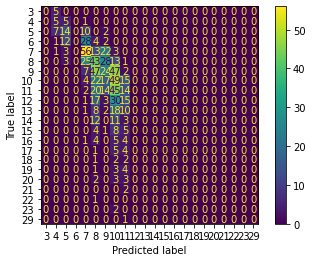

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='0.5g')

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.26      0.45      0.33        11
           5       0.38      0.42      0.40        33
           6       0.00      0.00      0.00        47
           7       0.41      0.57      0.48        98
           8       0.21      0.38      0.27       113
           9       0.21      0.19      0.20       127
          10       0.20      0.46      0.28       107
          11       0.16      0.15      0.16        95
          12       0.00      0.00      0.00        66
          13       0.00      0.00      0.00        39
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
from sklearn.model_selection import cross_val_score
acc = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)
print(f"Accuracy of each fold: {acc * 100}")
print(f'Accuracy: {acc.mean()}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


Accuracy of each fold: [27.46268657 22.45508982 23.95209581 24.5508982  24.25149701 23.95209581
 25.4491018  30.83832335 26.34730539 26.04790419]
Accuracy: 0.25530699794440964


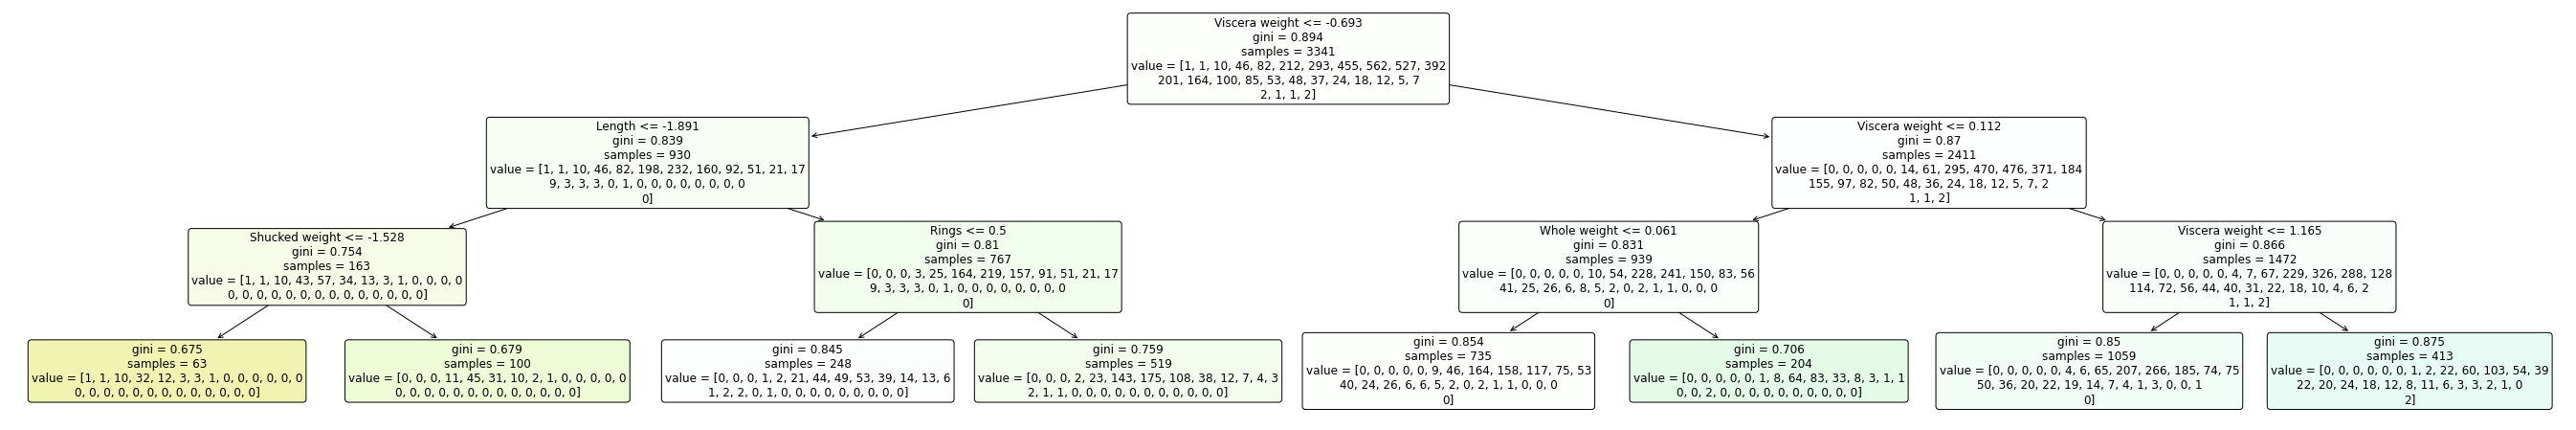

In [49]:
from sklearn import tree
plt.figure(figsize=(48, 8), facecolor='w')
a = tree.plot_tree(clf[-1], feature_names=column_names, rounded=True, filled=True, fontsize=12)
plt.show()

### Find best parameters using GridSearchCV

In [50]:
y_train.unique()

array([ 5,  3, 15, 10, 14, 11,  7, 19,  9, 12,  8, 13, 18, 16,  4,  6, 17,
       24, 22, 20,  2, 21, 23, 25, 27, 26,  1])

In [51]:
X_train_new = preprocessor.fit_transform(X_train)

In [52]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'max_depth': [1,2,3,4,5,6,7,8,9], 'min_samples_split': [2,4,5,8,10]}
clf_cv = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring='recall_macro')
clf_cv.fit(X_train_new, y_train)

# Alternatively...
# tuned_parameters = {'classifier__max_depth': [1,2,3,4,5,6,7,8,9], 'classifier__min_samples_split': [2,4,5,8,10]}
# clf_cv = GridSearchCV(clf, tuned_parameters)
# clf_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavio

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 4, 5, 8, 10]},
             scoring='recall_macro')

In [53]:
clf_cv.best_params_

{'max_depth': 5, 'min_samples_split': 4}

In [54]:
means = clf_cv.cv_results_['mean_test_score']
stds = clf_cv.cv_results_['std_test_score']
params = clf_cv.cv_results_['params']
for mean, std, param in zip(means, stds, params):
  print(f'{mean} +-{std} for {param}')

0.07344207874521547 +-0.004435943588474353 for {'max_depth': 1, 'min_samples_split': 2}
0.07344207874521547 +-0.004435943588474353 for {'max_depth': 1, 'min_samples_split': 4}
0.07344207874521547 +-0.004435943588474353 for {'max_depth': 1, 'min_samples_split': 5}
0.07344207874521547 +-0.004435943588474353 for {'max_depth': 1, 'min_samples_split': 8}
0.07344207874521547 +-0.004435943588474353 for {'max_depth': 1, 'min_samples_split': 10}
0.10723415459424324 +-0.00544146062020347 for {'max_depth': 2, 'min_samples_split': 2}
0.10723415459424324 +-0.00544146062020347 for {'max_depth': 2, 'min_samples_split': 4}
0.10723415459424324 +-0.00544146062020347 for {'max_depth': 2, 'min_samples_split': 5}
0.10723415459424324 +-0.00544146062020347 for {'max_depth': 2, 'min_samples_split': 8}
0.10723415459424324 +-0.00544146062020347 for {'max_depth': 2, 'min_samples_split': 10}
0.13136264544436022 +-0.0060588931656081375 for {'max_depth': 3, 'min_samples_split': 2}
0.13136264544436022 +-0.0060588931

#### With the best parameters

In [55]:
clf2 = Pipeline([('preprocessor', preprocessor),
                 ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42))])
clf2.fit(X_train, y_train)
print(clf2.score(X_test, y_test))

0.2715311004784689


There's a marginal improvement in the score, due to GridSearchCV

# Iris dataset

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text

In [58]:
X, y = load_iris(return_X_y=True, as_frame=True)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
dt_pipeline = Pipeline([('feature_scaling', MinMaxScaler()),
                        ('dt_classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])

In [61]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                ('dt_classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

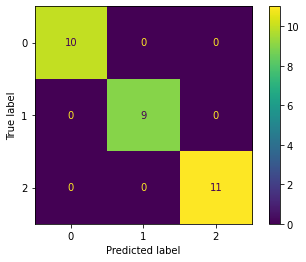

In [62]:
ConfusionMatrixDisplay.from_estimator(dt_pipeline, X_test, y_test)

In [63]:
print(classification_report(y_test, dt_pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [64]:
data = load_iris()


In [65]:
data

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========

In [66]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

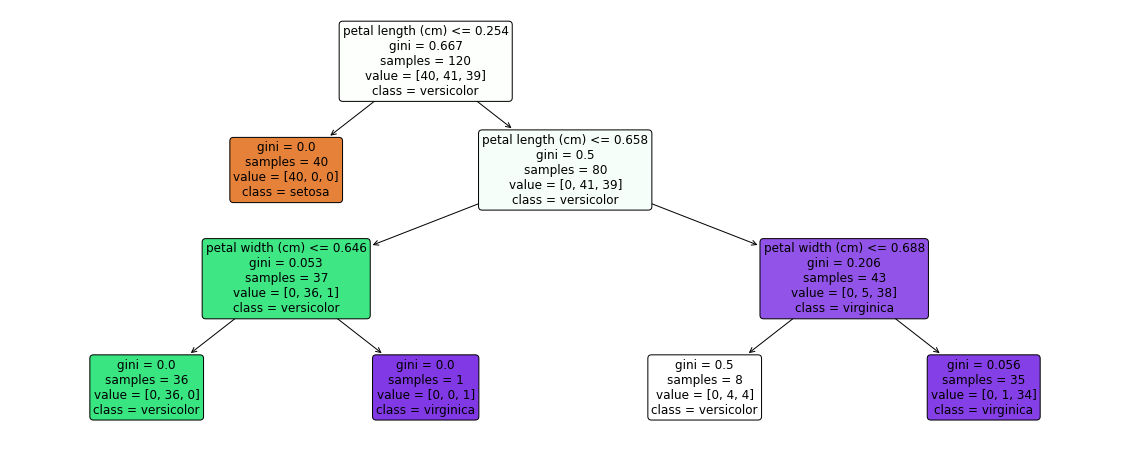

In [67]:
plt.figure(figsize=(20, 8), facecolor='w')
a = tree.plot_tree(dt_pipeline[-1], feature_names=data.feature_names, 
                   class_names=data.target_names, rounded=True, filled=True, fontsize=12)

Converting above plot into a if-else set of rules.

In [68]:
tree_rules = export_text(dt_pipeline[-1], feature_names=data.feature_names)
print(tree_rules)

|--- petal length (cm) <= 0.25
|   |--- class: 0
|--- petal length (cm) >  0.25
|   |--- petal length (cm) <= 0.66
|   |   |--- petal width (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.66
|   |   |--- petal width (cm) <= 0.69
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.69
|   |   |   |--- class: 2



What are the feature importances?

In [69]:
importance = pd.DataFrame({'feature': data.feature_names,
                           'importance': np.round(dt_pipeline[-1].feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace=True)
print(importance)

             feature  importance
2  petal length (cm)       0.935
3   petal width (cm)       0.065
0  sepal length (cm)       0.000
1   sepal width (cm)       0.000


### Find best parameters using GridSearchCV

In [70]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'dt_classifier__max_depth': [1,2,3,4,5], 'dt_classifier__min_samples_split': [2,4,6,8,10]}
clf_cv = GridSearchCV(dt_pipeline, tuned_parameters, scoring='f1_macro')
clf_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                                       ('dt_classifier',
                                        DecisionTreeClassifier(max_depth=3,
                                                               random_state=42))]),
             param_grid={'dt_classifier__max_depth': [1, 2, 3, 4, 5],
                         'dt_classifier__min_samples_split': [2, 4, 6, 8, 10]},
             scoring='f1_macro')

In [71]:
clf_cv.best_params_

{'dt_classifier__max_depth': 4, 'dt_classifier__min_samples_split': 2}

In [72]:
means = clf_cv.cv_results_['mean_test_score']
stds = clf_cv.cv_results_['std_test_score']
params = clf_cv.cv_results_['params']
for mean, std, param in zip(means, stds, params):
  print(f'{mean} +-{std} for {param}')

0.559111111111111 +-0.0071111111111111566 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 2}
0.559111111111111 +-0.0071111111111111566 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 4}
0.559111111111111 +-0.0071111111111111566 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 6}
0.559111111111111 +-0.0071111111111111566 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 8}
0.559111111111111 +-0.0071111111111111566 for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 10}
0.916065792938858 +-0.045340507280153944 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 2}
0.916065792938858 +-0.045340507280153944 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 4}
0.916065792938858 +-0.045340507280153944 for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 6}
0.916065792938858 +-0.045340507280153944 for {'dt_classifier__max_

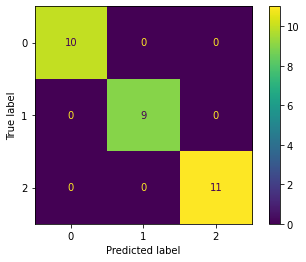

In [73]:
ConfusionMatrixDisplay.from_estimator(clf_cv.best_estimator_, X_test, y_test)